In [1]:
import numpy as np
from pprint import pprint
from copy import deepcopy


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup
from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType




# descriptor = generate_descriptor(
#     #pqsc=[""], # 장비 여러개 사용시
#     shfqc_6=["DEV12256"], 
#     number_data_qubits=3,
#     multiplex=True,
#     number_multiplex=6,
#     include_cr_lines=False,
#     include_ef_lines=True,
#     get_zsync=False,  # Only set to True when using real device
#     save = True,
#     filename="1port",
#     ip_address="192.168.0.83"
# )


#descriptor
#setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
setup = DeviceSetup.from_yaml(filepath="/Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/Descriptors/1port.yaml" , server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments


bus_ids = [f"b{i}" for i in range(3)]
bus_port = [4,5,6] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )

from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


# from laboneq.simple import workflow
# folder_store = workflow.logbook.FolderStore("./experiment_store") 
# folder_store.activate()
# #folder_store.deactivate()
# #workflow.logbook.LoggingStore().activate()
# #workflow.logbook.LogbookStore().deactivate()

import os
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store")
folder_store.activate()

fuck
LOADED: ./qpu_parameters/20260216-1700_save_test2


# CONNECTION

In [2]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=False, do_emulation=False)
#session.disconnect()

[2026.02.16 20:29:18.881] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.02.16 20:29:18.882] INFO    VERSION: laboneq 25.10.3
[2026.02.16 20:29:18.883] INFO    Connecting to data server at 192.168.0.83:8004
[2026.02.16 20:29:19.004] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.02.16 20:29:19.047] INFO    Configuring the device setup
[2026.02.16 20:29:19.075] INFO    The device setup is configured


# 정리된 Readout 최적화 흐름

1) Readout frequency (coarse sweep, wide)
2) Integration window (delay+length sweep)
3) Readout length sweep
4) Readout frequency (re-sweep, tighter)
5) Readout amplitude sweep
6) Readout frequency (final short convergence)

# Dispersive Shift

In [ ]:

# from experiments import dispersive_shift

# #######################################################################
# q = qubits[0]
# temporary_parameters = {}
# temp_pars =deepcopy(q.parameters)
# temporary_parameters[q.uid] = temp_pars

# print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
# #######################################################################
# options = dispersive_shift.experiment_workflow.options()
# options.count(1024)
# options.update(False)
# #print(workflow.show_fields(options))

# ###################################################################
# dispersive = dispersive_shift.experiment_workflow(
#     session=session,
#     qpu=qpu,
#     qubit=q,
#     frequencies=q.parameters.readout_resonator_frequency + np.linspace(-5e6,5e6,201),
#     options=options,
#     states='ge',
#     temporary_parameters=temporary_parameters
# )

# dispersive_result = dispersive.run() 
# print(dispersive_result.tasks['analysis_workflow'].output)

# Converged Readout Optimization

목표 순서: `frequency → integration window(delay+length) → readout length → frequency re-sweep → amplitude → short frequency re-sweep`

아래 셀은 이전 1~4 스텝을 한 번에 묶은 실행 예시입니다. 각 스텝은 직전 결과의 최적값을 다음 스텝의 `temporary_parameters`로 넘겨서 수렴 형태로 진행합니다.

In [3]:
from copy import deepcopy
from pprint import pprint
import numpy as np

from experiments import (
    readout_frequency_sweep,
    readout_integration_delay_sweep,
    readout_length_sweep,
    readout_amplitude_sweep,
)


def _safe_output_unwrap(obj, max_depth: int = 16):
    seen = set()
    queue = [(obj, 0)]

    while queue:
        current, depth = queue.pop(0)
        if depth > max_depth:
            continue

        if id(current) in seen:
            continue
        if current is None:
            continue
        seen.add(id(current))

        if isinstance(current, dict):
            if "analysis_result" in current and current["analysis_result"] is not None:
                queue.append((current["analysis_result"], depth + 1))
            if "output" in current and current["output"] is not None:
                queue.append((current["output"], depth + 1))
            for value in current.values():
                queue.append((value, depth + 1))
            continue

        if hasattr(current, "output"):
            queue.append((getattr(current, "output"), depth + 1))

        if hasattr(current, "analysis_result"):
            queue.append((getattr(current, "analysis_result"), depth + 1))

        if hasattr(current, "tasks"):
            queue.append((getattr(current, "tasks"), depth + 1))

        if isinstance(current, (list, tuple)):
            queue.extend((v, depth + 1) for v in current)
            continue

    return None


def _iter_candidate_dicts(obj, max_depth: int = 20):
    seen = set()
    stack = [(obj, 0)]

    while stack:
        current, depth = stack.pop()
        if depth > max_depth:
            continue

        oid = id(current)
        if oid in seen:
            continue
        seen.add(oid)

        if current is None:
            continue

        if isinstance(current, dict):
            has_best = isinstance(current.get("best_point"), dict)
            has_quality = "quality_flag" in current
            if has_best and has_quality:
                yield current
            if "analysis_result" in current:
                stack.append((current["analysis_result"], depth + 1))
            if "output" in current:
                stack.append((current["output"], depth + 1))
            for value in current.values():
                stack.append((value, depth + 1))
            continue

        if hasattr(current, "tasks"):
            stack.append((getattr(current, "tasks"), depth + 1))
        if hasattr(current, "output"):
            stack.append((getattr(current, "output"), depth + 1))
        if hasattr(current, "analysis_result"):
            stack.append((getattr(current, "analysis_result"), depth + 1))

        if isinstance(current, (list, tuple)):
            stack.extend((v, depth + 1) for v in current)
            continue

        if hasattr(current, "__dict__"):
            d = current.__dict__
            for value in d.values():
                stack.append((value, depth + 1))


def extract_analysis_output(workflow_result):
    # 1) direct best-point dictionaries
    for candidate in _iter_candidate_dicts(workflow_result):
        return candidate

    # 2) fallback legacy behavior
    out = _safe_output_unwrap(workflow_result)
    if isinstance(out, dict) and "best_point" in out:
        return out

    tasks = getattr(workflow_result, "tasks", None)
    if tasks is not None:
        try:
            iterable = tasks.values() if hasattr(tasks, "values") else tasks
            for t in iterable:
                for candidate in _iter_candidate_dicts(t):
                    return candidate
        except Exception:
            pass

    raise RuntimeError("Could not extract analysis output containing best_point.")


def _make_temp_params(qubit, state):
    temp = deepcopy(qubit.parameters)
    for k, v in state.items():
        if hasattr(temp, k):
            setattr(temp, k, v)
    return {qubit.uid: temp}


def _q_state_from_qubit(qubit):
    return {
        "readout_resonator_frequency": float(qubit.parameters.readout_resonator_frequency),
        "readout_integration_delay": float(qubit.parameters.readout_integration_delay or 0.0),
        "readout_integration_length": float(qubit.parameters.readout_integration_length),
        "readout_length": float(qubit.parameters.readout_length),
        "readout_amplitude": float(qubit.parameters.readout_amplitude),
    }


def _append_history(history, step, analysis, detail, q):
    uid = q.uid
    best = analysis["best_point"]
    history.append(
        {
            "step": step,
            "quality": analysis["quality_flag"],
            "detail": detail,
            "best_point": best,
            "new_parameter_values": analysis["new_parameter_values"].get(uid, {}),
        }
    )


def run_readout_converged_workflow(
    q,
    qpu,
    session,
    *,
    state=None,
    freq_span_initial=1.0e6,
    freq_points_initial=13,
    freq_span_mid=250e3,
    freq_points_mid=11,
    freq_span_short=80e3,
    freq_points_short=9,
    window_delay_span=30e-9,
    window_length_factors=(0.7, 0.85, 1.0, 1.15, 1.3),
    readout_lengths=(0.5, 0.7, 0.9, 1.0, 1.2, 1.4),
    amp_frac=0.2,
    amp_points=13,
    count_freq=1024,
    count_other=512,
    do_plot=True,
    plot_iq_cloud=True,
    max_readout_length=2.048e-6,
):
    if state is None:
        state = _q_state_from_qubit(q)

    history = []

    # 1) frequency (coarse)
    center_f = state["readout_resonator_frequency"]
    freqs = np.linspace(center_f - freq_span_initial, center_f + freq_span_initial, freq_points_initial)
    opts = readout_frequency_sweep.experiment_workflow.options()
    opts.do_analysis(True)
    opts.update(False)
    opts.count(int(count_freq))
    if not do_plot:
        opts.do_plotting(False)

    wf = readout_frequency_sweep.experiment_workflow(
        session=session,
        qpu=qpu,
        qubit=q,
        frequencies=freqs,
        temporary_parameters=_make_temp_params(q, state),
        options=opts,
    )
    ana = extract_analysis_output(wf.run())
    best = ana["new_parameter_values"][q.uid]
    state.update({"readout_resonator_frequency": float(best["readout_resonator_frequency"])})
    _append_history(history, "freq-coarse", ana, f"center={center_f:.6f}Hz ± {freq_span_initial:.0f}Hz", q)

    # 2) integration delay + integration length window
    center_delay = state["readout_integration_delay"]
    center_length = state["readout_integration_length"]
    delays = np.linspace(max(0.0, center_delay - window_delay_span), center_delay + window_delay_span, 13)
    integration_lengths = np.asarray(window_length_factors, dtype=float) * center_length
    if max_readout_length is not None:
        max_delay_in_sweep = float(np.max(delays))
        integration_cap = float(max_readout_length) - max_delay_in_sweep
        if integration_cap <= 0.0:
            raise ValueError("No valid integration_length under measure-section limit.")
        integration_lengths = np.clip(integration_lengths, 0.0, integration_cap)
        integration_lengths = np.unique(integration_lengths)

    opts = readout_integration_delay_sweep.experiment_workflow.options()
    opts.do_analysis(True)
    opts.update(False)
    opts.count(int(count_other))
    if not do_plot:
        opts.do_plotting(False)

    wf = readout_integration_delay_sweep.experiment_workflow(
        session=session,
        qpu=qpu,
        qubit=q,
        delays=delays,
        integration_lengths=integration_lengths,
        temporary_parameters=_make_temp_params(q, state),
        options=opts,
    )
    ana = extract_analysis_output(wf.run())
    best = ana["new_parameter_values"][q.uid]
    state.update(
        {
            "readout_integration_delay": float(best["readout_integration_delay"]),
            "readout_integration_length": float(best["readout_integration_length"]),
        }
    )
    if max_readout_length is not None:
        max_len_for_state = float(max_readout_length) - float(state["readout_integration_delay"])
        if max_len_for_state <= 0.0:
            raise ValueError("readout_integration_delay leaves no integration window budget.")
        state["readout_integration_length"] = min(
            float(state["readout_integration_length"]),
            max_len_for_state,
        )
    _append_history(history, "integration-window", ana, "simultaneous sweep", q)

    # 3) readout length
    base_len = state["readout_length"]
    readout_length_points = np.asarray(readout_lengths, dtype=float) * base_len
    if max_readout_length is not None:
        readout_length_points = np.clip(readout_length_points, 0.0, float(max_readout_length))
        readout_length_points = np.unique(readout_length_points)
    if readout_length_points.size < 1:
        raise ValueError("No valid readout_length points after safety clipping.")
    opts = readout_length_sweep.experiment_workflow.options()
    opts.do_analysis(True)
    opts.update(False)
    opts.count(int(count_other))
    if max_readout_length is not None and hasattr(opts, "max_readout_length"):
        opts.max_readout_length(float(max_readout_length))
    if not do_plot:
        opts.do_plotting(False)

    wf = readout_length_sweep.experiment_workflow(
        session=session,
        qpu=qpu,
        qubit=q,
        readout_lengths=readout_length_points,
        temporary_parameters=_make_temp_params(q, state),
        options=opts,
    )
    ana = extract_analysis_output(wf.run())
    best = ana["new_parameter_values"][q.uid]
    state.update({"readout_length": float(best["readout_length"])})
    _append_history(history, "readout-length", ana, f"scaled factors={tuple(readout_lengths)}", q)

    # 4) re-sweep frequency around updated point
    center_f = state["readout_resonator_frequency"]
    freqs = np.linspace(center_f - freq_span_mid, center_f + freq_span_mid, freq_points_mid)
    opts = readout_frequency_sweep.experiment_workflow.options()
    opts.do_analysis(True)
    opts.update(False)
    opts.count(int(count_freq))
    if not do_plot:
        opts.do_plotting(False)
    if not plot_iq_cloud:
        opts.do_plotting_optimal_iq_cloud(False)

    wf = readout_frequency_sweep.experiment_workflow(
        session=session,
        qpu=qpu,
        qubit=q,
        frequencies=freqs,
        temporary_parameters=_make_temp_params(q, state),
        options=opts,
    )
    ana = extract_analysis_output(wf.run())
    best = ana["new_parameter_values"][q.uid]
    state.update({"readout_resonator_frequency": float(best["readout_resonator_frequency"])})
    _append_history(history, "freq-refine-1", ana, f"center={center_f:.6f}Hz ± {freq_span_mid:.0f}Hz", q)

    # 5) readout amplitude
    base_amp = state["readout_amplitude"]
    amp_span = max(0.05, abs(base_amp) * amp_frac)
    amp_lo = max(0.0, base_amp - amp_span)
    amp_hi = min(1.0, base_amp + amp_span)
    if np.isclose(amp_lo, amp_hi):
        amp_lo = max(0.0, base_amp - 0.02)
        amp_hi = min(1.0, base_amp + 0.02)
        if np.isclose(amp_lo, amp_hi):
            amp_lo = max(0.0, base_amp * 0.8)
            amp_hi = min(1.0, base_amp * 1.2)

    amplitudes = np.linspace(amp_lo, amp_hi, amp_points)
    opts = readout_amplitude_sweep.experiment_workflow.options()
    opts.do_analysis(True)
    opts.update(False)
    opts.count(int(count_freq))
    if not do_plot:
        opts.do_plotting(False)

    wf = readout_amplitude_sweep.experiment_workflow(
        session=session,
        qpu=qpu,
        qubit=q,
        amplitudes=amplitudes,
        temporary_parameters=_make_temp_params(q, state),
        options=opts,
    )
    ana = extract_analysis_output(wf.run())
    best = ana["new_parameter_values"][q.uid]
    state.update({"readout_amplitude": float(best["readout_amplitude"])})
    _append_history(history, "amplitude", ana, f"sweep={amp_lo:.4f} ~ {amp_hi:.4f}", q)

    # 6) final short frequency refinement
    center_f = state["readout_resonator_frequency"]
    freqs = np.linspace(center_f - freq_span_short, center_f + freq_span_short, freq_points_short)
    opts = readout_frequency_sweep.experiment_workflow.options()
    opts.do_analysis(True)
    opts.update(False)
    opts.count(int(count_freq))
    if not do_plot:
        opts.do_plotting(False)
    if not plot_iq_cloud:
        opts.do_plotting_optimal_iq_cloud(False)

    wf = readout_frequency_sweep.experiment_workflow(
        session=session,
        qpu=qpu,
        qubit=q,
        frequencies=freqs,
        temporary_parameters=_make_temp_params(q, state),
        options=opts,
    )
    ana = extract_analysis_output(wf.run())
    best = ana["new_parameter_values"][q.uid]
    state.update({"readout_resonator_frequency": float(best["readout_resonator_frequency"])})
    _append_history(history, "freq-refine-2", ana, f"center={center_f:.6f}Hz ± {freq_span_short:.0f}Hz", q)

    return state, history


def _print_history(history):
    for idx, item in enumerate(history, 1):
        best = item["best_point"]
        print(f"[{idx}] {item['step']:18s} quality={item['quality']:>14s} detail={item['detail']}")
        for k, v in best.items():
            if isinstance(v, (int, float)):
                print(f"    {k}: {v}")
        print(f"    updated: {item['new_parameter_values']}")


q = qubits[0]
state0 = _q_state_from_qubit(q)
print("initial state:")
pprint(state0)






initial state:
{'readout_amplitude': 0.5,
 'readout_integration_delay': 5e-07,
 'readout_integration_length': 1.3e-06,
 'readout_length': 1.3e-06,
 'readout_resonator_frequency': 7002450000.0}


## Run one converged optimization pass (예시): `freq -> window -> length -> freq -> amp -> freq(짧게)`

[2026.02.16 20:29:22.654] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.16 20:29:22.654] INFO      Workflow 'readout_frequency_sweep': execution started at 2026-02-16           
[2026.02.16 20:29:22.655] INFO      11:29:22.653461Z                                                              
[2026.02.16 20:29:22.656] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.16 20:29:22.690] INFO    Task '_resolve_frequencies': started at 2026-02-16 11:29:22.687304Z
[2026.02.16 20:29:22.698] INFO    Task '_resolve_frequencies': ended at 2026-02-16 11:29:22.698216Z
[2026.02.16 20:29:22.701] INFO    Task 'temporary_qpu': started at 2026-02-16 11:29:22.700599Z
[2026.02.16 20:29:22.702] INFO    Task 'temporary_qpu': ended at 2026-02-16 11:29:22.702027Z
[2026.02.16 20:29:22.711] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-16 
[2026.02.16 20:29:22.715] INFO    11:29:22.709445

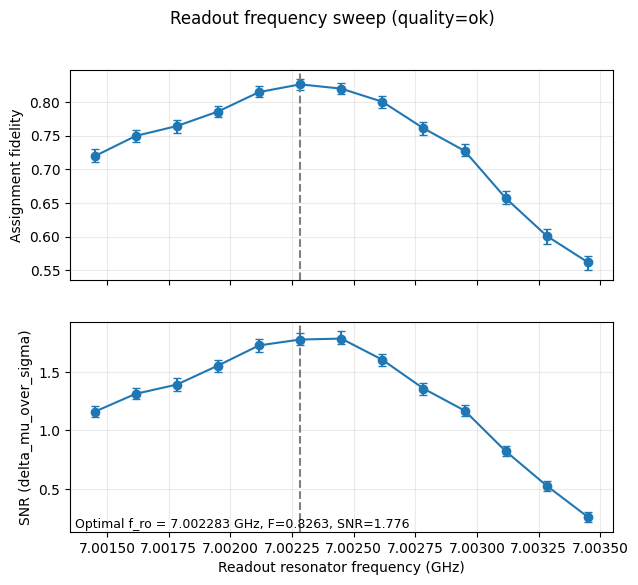

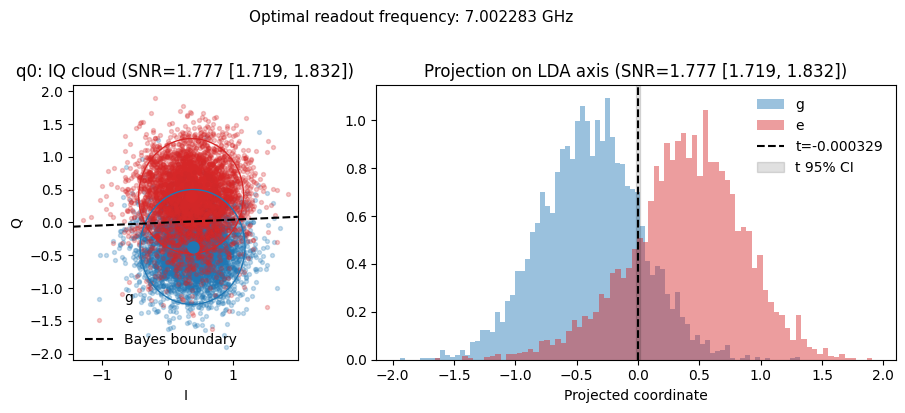

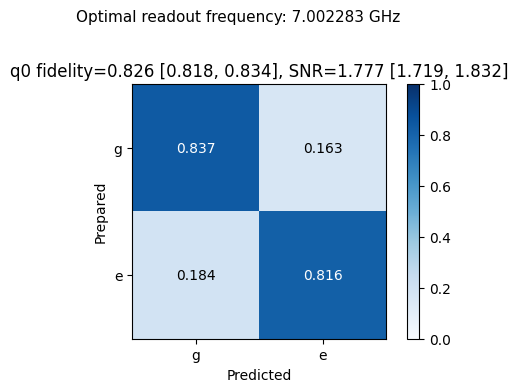

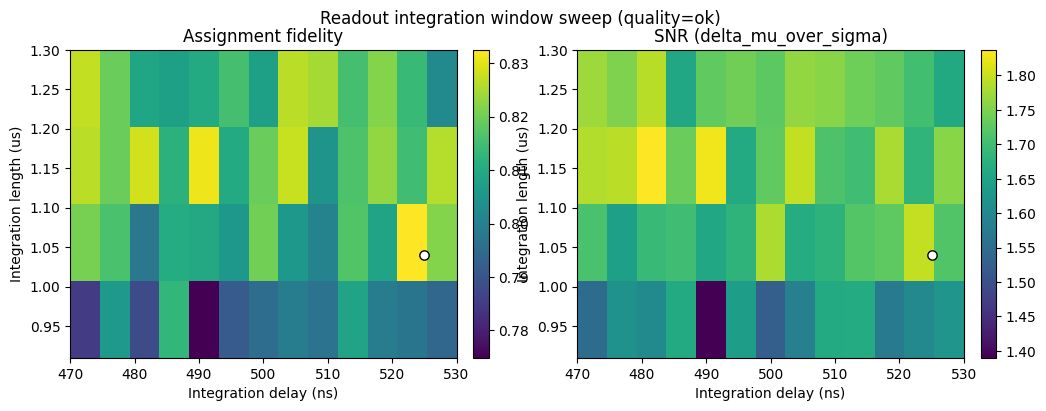

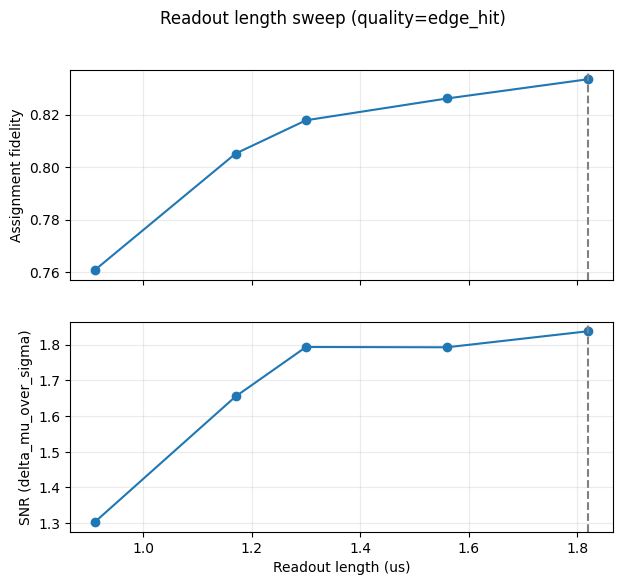

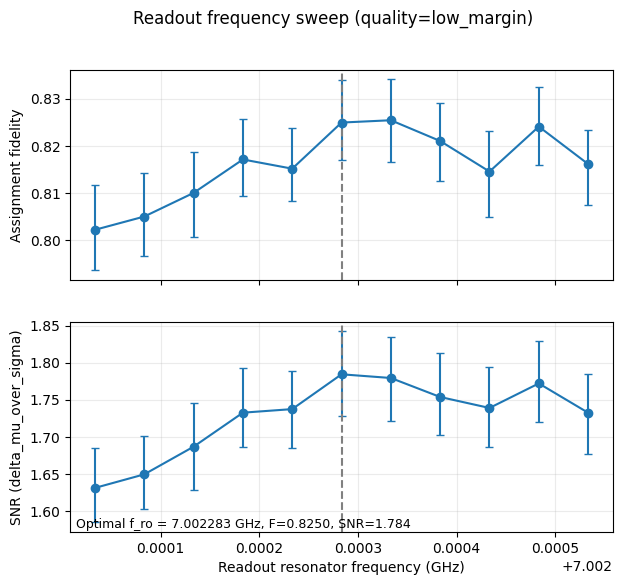

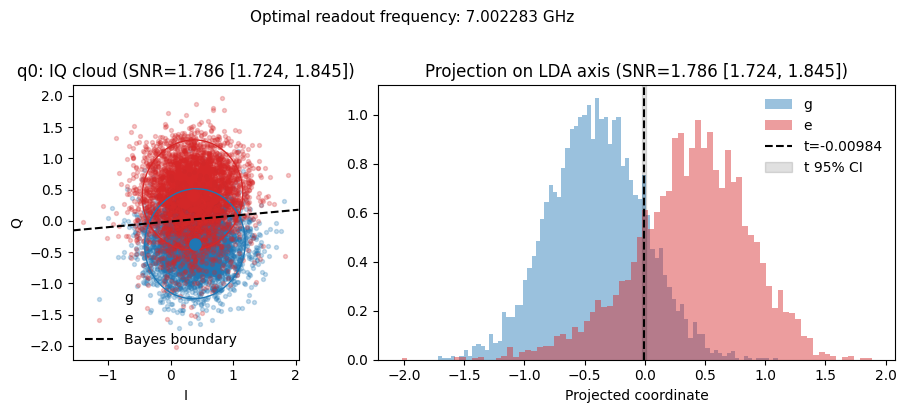

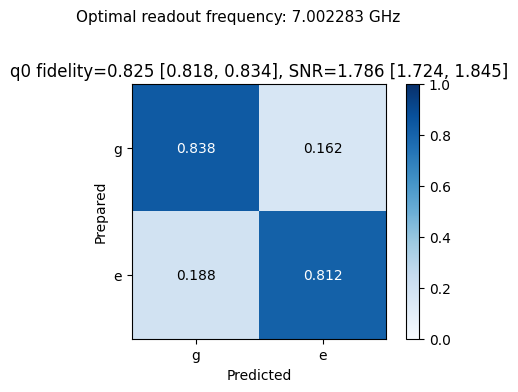

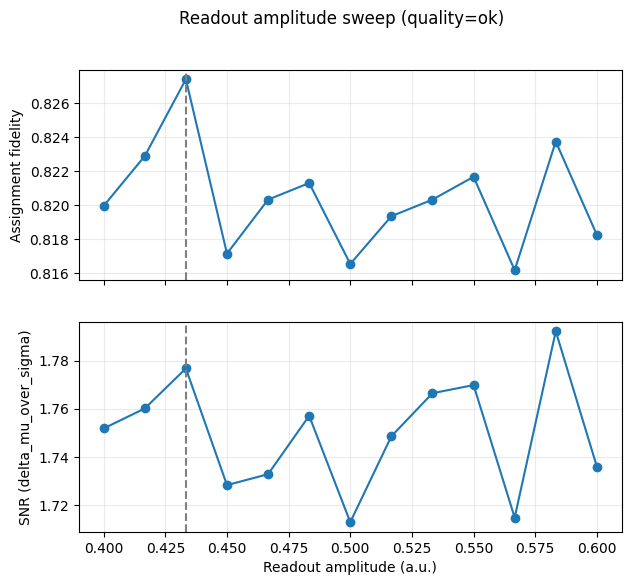

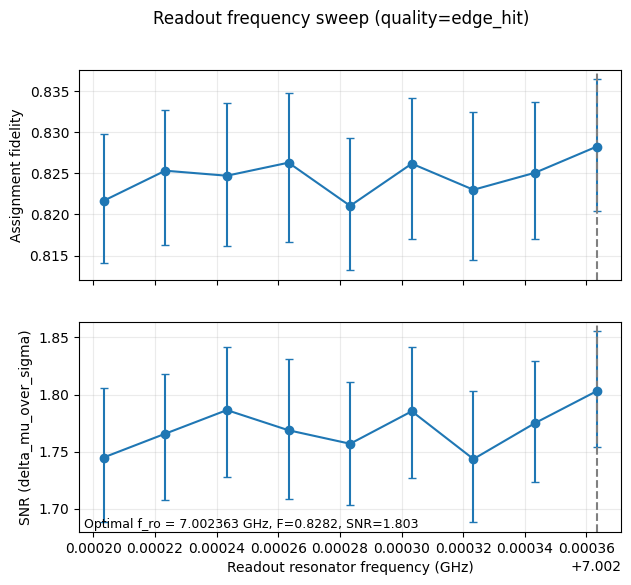

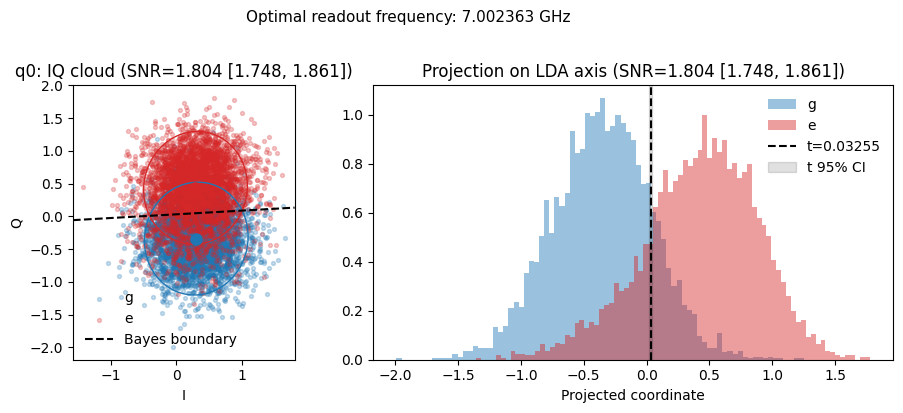

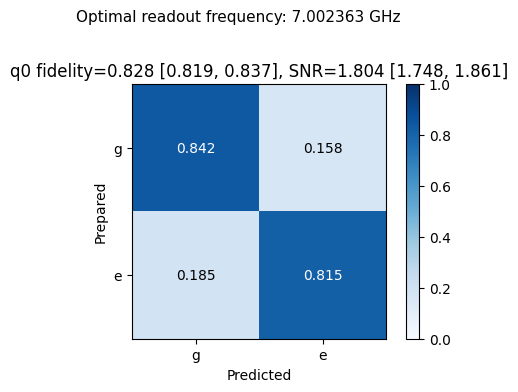

In [4]:
readout_state, readout_history = run_readout_converged_workflow(
    q=q,
    qpu=qpu,
    session=session,
    state=state0,
    freq_span_initial=1.0e6,
    freq_points_initial=13,
    window_delay_span=30e-9,
    window_length_factors=(0.7, 0.8, 0.9, 1.0),
    readout_lengths=(0.7, 0.9, 1.0, 1.2, 1.4),
    freq_span_mid=250e3,
    freq_points_mid=11,
    amp_frac=0.2,
    amp_points=13,
    freq_span_short=80e3,
    freq_points_short=9,
    count_freq=1024*4,
    count_other=1024,
    do_plot=True,
    plot_iq_cloud=True,
)

_print_history(readout_history)

print("final readout state (candidate):")
pprint(readout_state)


## MID-aware validation (optional)

최적화가 끝난 readout 주파수 후보를 `readout_mid_sweep`로 한 번 더 검증합니다.

In [24]:
import importlib
from experiments import readout_mid_sweep
importlib.reload(readout_mid_sweep)


<module 'experiments.readout_mid_sweep' from '/Users/yalgaeahn/JSAHN/qubit-experiment/experiments/readout_mid_sweep.py'>

[2026.02.16 22:22:34.884] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.16 22:22:34.886] INFO      Workflow 'readout_mid_sweep': execution started at 2026-02-16                 
[2026.02.16 22:22:34.886] INFO      13:22:34.884365Z                                                              
[2026.02.16 22:22:34.887] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.16 22:22:34.914] INFO    Task 'temporary_qpu': started at 2026-02-16 13:22:34.914417Z
[2026.02.16 22:22:34.919] INFO    Task 'temporary_qpu': ended at 2026-02-16 13:22:34.918979Z
[2026.02.16 22:22:34.925] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-16 
[2026.02.16 22:22:34.927] INFO    13:22:34.925132Z
[2026.02.16 22:22:34.928] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-16 13:22:34.928453Z
[2026.02.16 22:22:34.930] INFO    Task '_coerce_mid_frequencies': started at 2026-02-

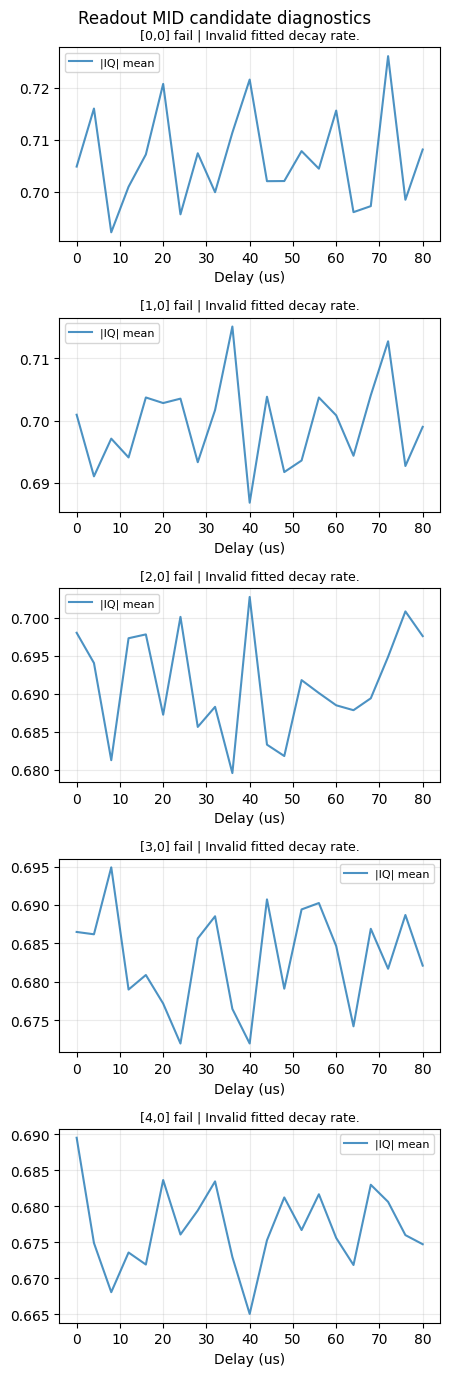

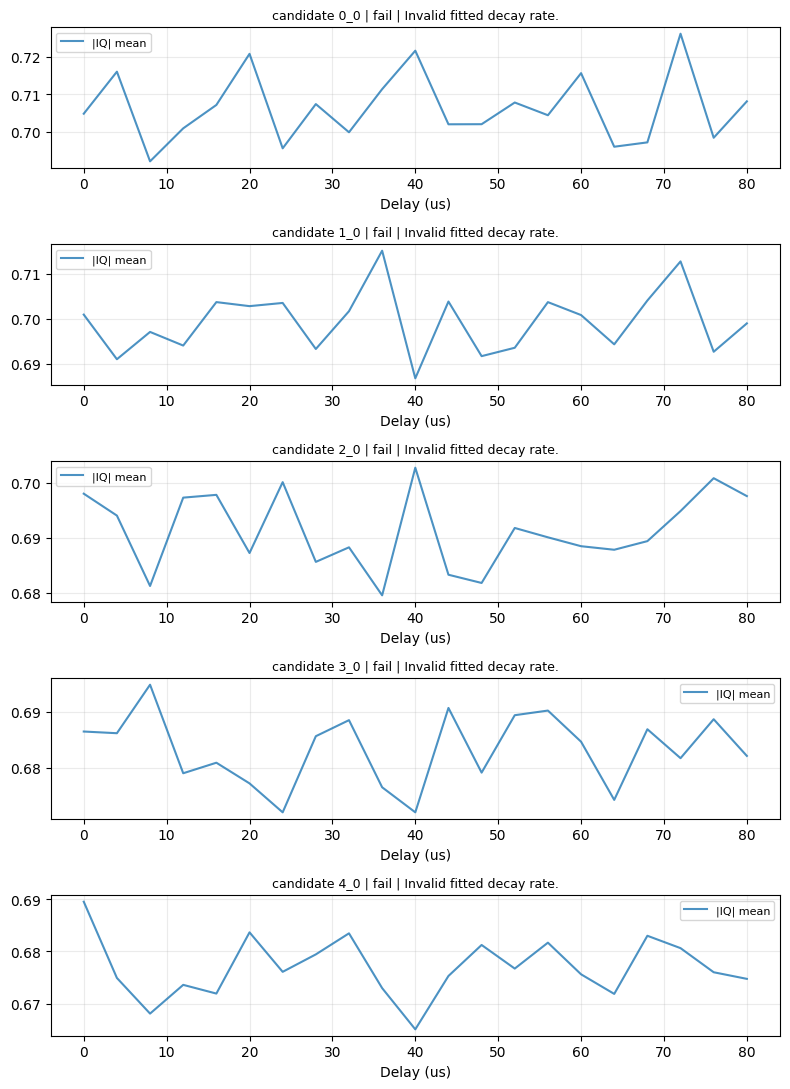

In [28]:
import importlib
import matplotlib.pyplot as plt
from experiments import readout_mid_sweep
from analysis import readout_mid_sweep as readout_mid_sweep_analysis
importlib.reload(readout_mid_sweep_analysis)
importlib.reload(readout_mid_sweep)


def _plot_mid_candidate_debug(mid_result, delays):
    diag = mid_result.get("candidate_fit_results", {})
    if not isinstance(diag, dict) or len(diag) == 0:
        print("[readout-mid-frequency] no candidate_fit_results to plot")
        return

    delays_us = np.asarray(delays, dtype=float).reshape(-1) * 1e6
    keys = sorted(diag.keys(), key=lambda x: tuple(int(t) for t in x.split("_")))
    n = len(keys)
    fig, axes = plt.subplots(n, 1, figsize=(8, max(2.5, 2.2 * n)), squeeze=False)

    for i, key in enumerate(keys):
        ax = axes[i][0]
        item = diag[key]
        pop = np.asarray(item.get("population", []), dtype=float).reshape(-1)
        raw_abs = np.asarray(item.get("raw_abs", []), dtype=float).reshape(-1)
        swpts = np.asarray(item.get("sweep_points", []), dtype=float).reshape(-1)
        x_pop = swpts * 1e6 if swpts.size else delays_us

        if pop.size > 0:
            xp = x_pop if x_pop.size == pop.size else np.linspace(delays_us.min(), delays_us.max(), pop.size)
            ax.plot(xp, pop, "o-", label="population")
        if raw_abs.size > 0:
            xr = delays_us if delays_us.size == raw_abs.size else np.linspace(delays_us.min(), delays_us.max(), raw_abs.size)
            ax.plot(xr, raw_abs, "-", alpha=0.8, label="|IQ| mean")

        fit_ok = bool(item.get("fit_success", False))
        err = str(item.get("error", ""))
        if len(err) > 120:
            err = err[:117] + "..."
        title = f"candidate {key} | {'ok' if fit_ok else 'fail'}"
        if err:
            title += f" | {err}"
        ax.set_title(title, fontsize=9)
        ax.set_xlabel("Delay (us)")
        ax.grid(alpha=0.25)
        if pop.size > 0 or raw_abs.size > 0:
            ax.legend(loc="best", fontsize=8)

    fig.tight_layout()
    plt.show()


def run_readout_mid_frequency_check(
    q,
    qpu,
    session,
    readout_state,
    delays=None,
    readout_span=40e3,
    readout_points=5,
):
    base_freq = float(readout_state["readout_resonator_frequency"])

    if delays is None:
        delays = np.linspace(0, 30e-6, 41)

    readout_freq_points = np.linspace(
        base_freq - readout_span,
        base_freq + readout_span,
        readout_points,
    )

    mid_opts = readout_mid_sweep.experiment_workflow.options()
    mid_opts.do_analysis(True)
    mid_opts.update(False)
    mid_opts.count(1024*2)

    wf = readout_mid_sweep.experiment_workflow(
        session=session,
        qpu=qpu,
        qubit=q,
        delays=delays,
        readout_resonator_frequencies=readout_freq_points,
        sweep_axis="frequency",
        temporary_parameters=_make_temp_params(q, readout_state),
        options=mid_opts,
    )

    run_result = wf.run()

    try:
        mid_result = extract_analysis_output(run_result)
    except RuntimeError:
        candidate = getattr(run_result, "output", None)
        if isinstance(candidate, dict) and "analysis_result" in candidate:
            candidate = candidate["analysis_result"]
        if hasattr(candidate, "output"):
            candidate = candidate.output
        if isinstance(candidate, dict) and "best_point" in candidate:
            mid_result = candidate
        else:
            raise

    print("[readout-mid-frequency] quality:", mid_result["quality_flag"])
    print("[readout-mid-frequency] best_point:", mid_result["best_point"])
    print("[readout-mid-frequency] mid_rate_at_best curve:")
    print(mid_result["metrics_vs_sweep"]["mid_rate_at_best"])
    print("[readout-mid-frequency] mid_gate_pass:", mid_result["best_point"].get("mid_gate_pass"))
    print(
        "[readout-mid-frequency] relative_mid_increase:",
        mid_result["best_point"].get("relative_mid_increase"),
    )

    diag = mid_result.get("candidate_fit_results", {})
    failed = {k: str(v.get("error", "")) for k, v in diag.items() if not v.get("fit_success", False)}
    if failed:
        print("[readout-mid-frequency] failed candidates:")
        for k, msg in failed.items():
            print(f"  - {k}: {msg}")

    _plot_mid_candidate_debug(mid_result, delays)
    return mid_result


mid_freq_result = run_readout_mid_frequency_check(
    q=q,
    qpu=qpu,
    session=session,
    readout_state=readout_state,
    delays=np.linspace(0, 80e-6, 21),
    readout_span=40e3,
    readout_points=5,
)



In [ ]:
# # Optional: apply candidate state to q (in-memory only)
# # NOTE: not yet persisted to qpu YAML unless you save(qpu, ...) later.

# apply = False  # <- True로 바꿔서 바로 반영

# if apply:
#     for k, v in readout_state.items():
#         if hasattr(q.parameters, k):
#             setattr(q.parameters, k, v)
#     print("Applied to q.parameters:", {k: getattr(q.parameters, k) for k in readout_state})
# else:
#     print("apply=True 를 눌러야 q.parameters에 반영됩니다.") 

# SAVE QPU

In [ ]:
from laboneq.serializers import save, load, from_dict, from_json, to_dict, to_json
import time

t = time.localtime()
timestamp = time.strftime('%Y%m%d-%H%M', t)

filename = "save_test2"
save(qpu, filename=f"./qpu_parameters/{timestamp}_{filename}")

